## Image classification of landscape pictures. 
This is image data of Natural Scenes around the world.
`The original dataset is available here` [dataset link](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

`This Data contains around 25k images of size 150x150 distributed under 6 categories.

'buildings' -> 0,

'forest' -> 1,

'glacier' -> 2,

'mountain' -> 3,

'sea' -> 4,

'street' -> 5 `

The Train, val, test and Prediction data is separated in folders. There are around 14k images in Train, 3k in validation and 64 in test and 7k in pred folder.

In [1]:
!unzip intel_image_classification.zip
# # !rm intel_image_classification.zip

/bin/bash: line 1: unzip: command not found


In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image


from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

import tensorflow.keras.applications.xception as xc
import tensorflow.keras.applications.mobilenet_v2 as mn
import tensorflow.keras.applications.nasnet as nas

from tensorflow.keras.applications.xception import Xception
import tensorflow.keras.applications.nasnet as nasnet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3


from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.xception import decode_predictions


Since this is image classification, we cannot do extensive EDA as like our previous machine learning project. We will plot the class distributions of images to uunderstand the categorical imbalance.

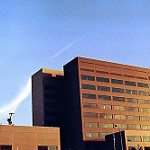

In [2]:
path = 'intel_image_classification/train/buildings'
name = '47.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [3]:
train_dir = Path('intel_image_classification/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

val_dir = Path('intel_image_classification/val')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

test_dir = Path('intel_image_classification/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='File_Location').astype(str)
    labels = pd.Series(labels, name='Category_Name')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)
full_train_df = pd.concat([train_df, val_df])

### Total number of classes availble in the model

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of classes: {len(train_df.Category_Name.unique())}\n')
print(f'Name of the classes: {train_df.Category_Name.unique()}')

-- Training set --

Number of pictures: 14034

Number of classes: 6

Name of the classes: ['glacier' 'mountain' 'buildings' 'sea' 'forest' 'street']


In [6]:
train_df.head()

,File_Location,Category_Name
0,intel_image_classification/train/glacier/1229.jpg,glacier
1,intel_image_classification/train/glacier/1044.jpg,glacier
2,intel_image_classification/train/mountain/1214...,mountain
3,intel_image_classification/train/buildings/664...,buildings
4,intel_image_classification/train/sea/4334.jpg,sea


In [7]:
dist = train_df['Category_Name'].value_counts()

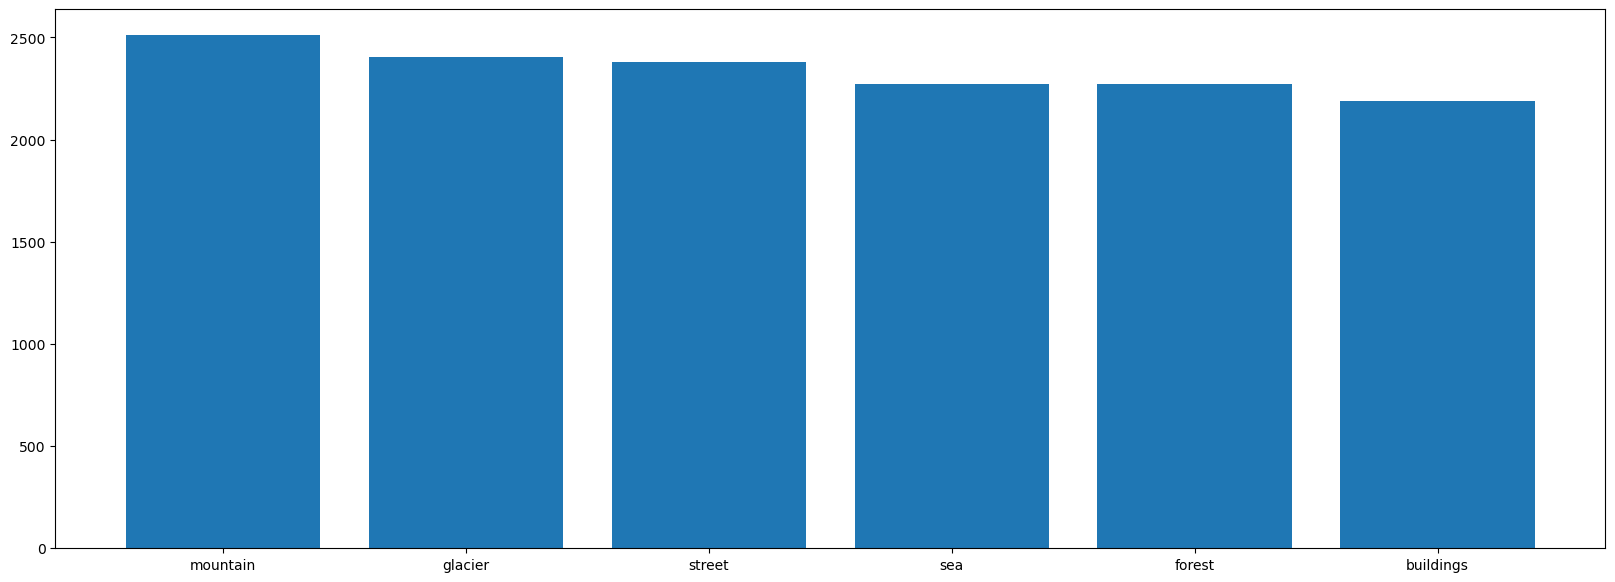

In [8]:
plt.figure(figsize=(20,7))
plt.bar(dist.axes[0].tolist(), dist.values.tolist())
plt.show()

In [9]:
dist.mode()

0    2191
1    2271
2    2274
3    2382
4    2404
5    2512
Name: Category_Name, dtype: int64

## Sample set of images for each category

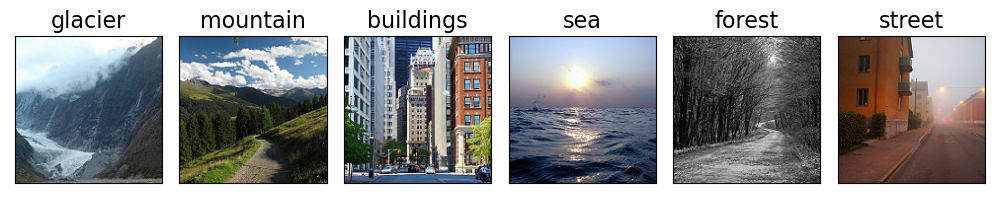

In [10]:
df_unique = train_df.copy().drop_duplicates(subset=["Category_Name"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes):
    ax.imshow(plt.imread(df_unique.File_Location[i]))
    ax.set_title(df_unique.Category_Name[i], fontsize = 16)
plt.tight_layout(pad=0.9)
plt.show()

In [11]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    'intel_image_classification/train',
    target_size=(150, 150),
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [13]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    'intel_image_classification/val',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3000 images belonging to 6 classes.


In [14]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

## Adjusting the learning rate

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/10
439/439 [==============================] - 44s 77ms/step - loss: 0.8100 - accuracy: 0.7548 - val_loss: 0.4603 - val_accuracy: 0.8627
Epoch 2/10
439/439 [==============================] - 32s 73ms/step - loss: 0.3933 - accuracy: 0.8762 - val_loss: 0.3553 - val_accuracy: 0.8817
Epoch 3/10
439/439 [==============================] - 33s 75ms/step - loss: 0.3280 - accuracy: 0.8888 - val_loss: 0.3179 - val_accuracy: 0.8917
Epoch 4/10
439/439 [==============================] - 33s 75ms/step - loss: 0.2992 - accuracy: 0.8969 - val_loss: 0.3007 - val_accuracy: 0.8960
Epoch 5/10
439/439 [==============================] - 33s 75ms/step - loss: 0.2819 - accuracy: 0.9016 - val_loss: 0.2883 - val_accuracy: 0.8960
Epoch 6/10
439/439 [==============================] - 33s 75ms/step - loss: 0.2694 - accuracy: 0.9054 - val_loss: 0.2813 - val_accuracy: 0.8997
Epoch 7/10
439/439 [==============================] - 33s 75ms/s

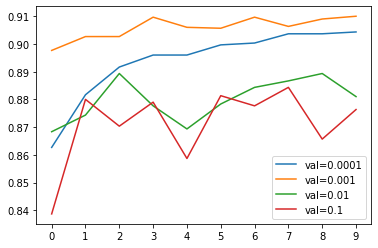

In [ ]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

### Based on the initial model performance with different learning rate. `0.001` has high accuracy. So we will proceed with it.

In [ ]:
learning_rate=0.001

In [ ]:
model.save_weights('model_xception_v1.h5', save_format='h5')

In [ ]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
439/439 [==============================] - 35s 75ms/step - loss: 0.3598 - accuracy: 0.8713 - val_loss: 0.2704 - val_accuracy: 0.9017
Epoch 2/10
439/439 [==============================] - 32s 74ms/step - loss: 0.2485 - accuracy: 0.9091 - val_loss: 0.2783 - val_accuracy: 0.8993
Epoch 3/10
439/439 [==============================] - 33s 76ms/step - loss: 0.2254 - accuracy: 0.9189 - val_loss: 0.2525 - val_accuracy: 0.9063
Epoch 4/10
439/439 [==============================] - 33s 75ms/step - loss: 0.2048 - accuracy: 0.9248 - val_loss: 0.2565 - val_accuracy: 0.9047
Epoch 5/10
439/439 [==============================] - 34s 76ms/step - loss: 0.1915 - accuracy: 0.9281 - val_loss: 0.2623 - val_accuracy: 0.9073
Epoch 6/10
439/439 [==============================] - 33s 75ms/step - loss: 0.1804 - accuracy: 0.9330 - val_loss: 0.2812 - val_accuracy: 0.8930
Epoch 7/10
439/439 [==============================] - 34s 78ms/step - loss: 0.1713 - accuracy: 0.9376 - val_loss: 0.2596 - val_accuracy:

## Adding more layers
* Adding one inner dense layer
* Experimenting with different sizes of inner layer

In [ ]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
439/439 [==============================] - 36s 76ms/step - loss: 0.5009 - accuracy: 0.8261 - val_loss: 0.2876 - val_accuracy: 0.8960
Epoch 2/10
439/439 [==============================] - 33s 75ms/step - loss: 0.2609 - accuracy: 0.9079 - val_loss: 0.2771 - val_accuracy: 0.9000
Epoch 3/10
439/439 [==============================] - 34s 77ms/step - loss: 0.2334 - accuracy: 0.9151 - val_loss: 0.2642 - val_accuracy: 0.9020
Epoch 4/10
439/439 [==============================] - 33s 76ms/step - loss: 0.2121 - accuracy: 0.9221 - val_loss: 0.2679 - val_accuracy: 0.9013
Epoch 5/10
439/439 [==============================] - 33s 76ms/step - loss: 0.1978 - accuracy: 0.9255 - val_loss: 0.2608 - val_accuracy: 0.9050
Epoch 6/10
439/439 [==============================] - 34s 77ms/step - loss: 0.1851 - accuracy: 0.9325 - val_loss: 0.2694 - val_accuracy: 0.9050
Epoch 7/10
439/439 [==============================] - 33s 76ms/step - loss: 0.1736 - accuracy: 0.9369 - val_loss: 0.2593 - val_accura

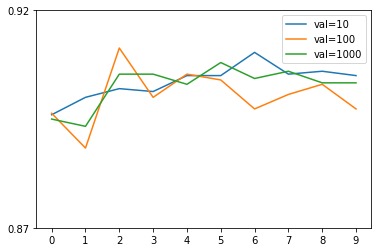

In [ ]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.87, 0.92])
plt.legend()

### Based on result, `size_inner=100` is considerred for further iterations and tuning.

## Regularization and dropout
* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [14]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
439/439 [==============================] - 35s 74ms/step - loss: 0.3280 - accuracy: 0.8796 - val_loss: 0.2906 - val_accuracy: 0.8963
Epoch 2/30
439/439 [==============================] - 32s 73ms/step - loss: 0.2345 - accuracy: 0.9118 - val_loss: 0.3361 - val_accuracy: 0.8753
Epoch 3/30
439/439 [==============================] - 33s 75ms/step - loss: 0.1989 - accuracy: 0.9253 - val_loss: 0.2579 - val_accuracy: 0.9047
Epoch 4/30
439/439 [==============================] - 33s 75ms/step - loss: 0.1727 - accuracy: 0.9349 - val_loss: 0.2616 - val_accuracy: 0.9000
Epoch 5/30
439/439 [==============================] - 33s 75ms/step - loss: 0.1520 - accuracy: 0.9411 - val_loss: 0.2976 - val_accuracy: 0.9047
Epoch 6/30
439/439 [==============================] - 33s 76ms/step - loss: 0.1316 - accuracy: 0.9486 - val_loss: 0.2893 - val_accuracy: 0.8993
Epoch 7/30
439/439 [==============================] - 33s 76ms/step - loss: 0.1132 - accuracy: 0.9565 - val_loss: 0.3000 - val_accur

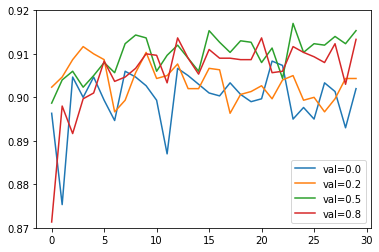

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.87, 0.92)
plt.legend()

## Droprate 0.5 is considered based on validation accuracy

In [15]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = train_gen.flow_from_directory(
    'intel_image_classification/train',
    target_size=(150, 150),
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [16]:
learning_rate = 0.001
size = 100
droprate = 0.5

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=5, validation_data=val_ds)

2022-12-20 23:06:37.938127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:06:38.039429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:06:38.040105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:06:38.041645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/5


2022-12-20 23:06:45.589404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-20 23:06:47.728807: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 23:06:47.729689: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 23:06:47.729730: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-20 23:06:47.730728: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 23:06:47.730833: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


439/439 [==============================] - 90s 188ms/step - loss: 0.5929 - accuracy: 0.7874 - val_loss: 0.3285 - val_accuracy: 0.8820
Epoch 2/5
439/439 [==============================] - 81s 184ms/step - loss: 0.4783 - accuracy: 0.8278 - val_loss: 0.3073 - val_accuracy: 0.8840
Epoch 3/5
439/439 [==============================] - 82s 186ms/step - loss: 0.4433 - accuracy: 0.8390 - val_loss: 0.3055 - val_accuracy: 0.8867
Epoch 4/5
439/439 [==============================] - 82s 188ms/step - loss: 0.4323 - accuracy: 0.8406 - val_loss: 0.3051 - val_accuracy: 0.8903
Epoch 5/5
439/439 [==============================] - 81s 184ms/step - loss: 0.4199 - accuracy: 0.8514 - val_loss: 0.3052 - val_accuracy: 0.8780


### Results are not improved with data augmentations. We will ignore the data augmentation for our final model

## Training a larger model

In [45]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [46]:
input_size = 299

In [49]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    'intel_image_classification/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    'intel_image_classification/val',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [48]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [50]:
learning_rate = 0.0005
size = 100
droprate = 0.5

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50
439/439 [==============================] - 121s 269ms/step - loss: 0.3687 - accuracy: 0.8678 - val_loss: 0.2216 - val_accuracy: 0.9173
Epoch 2/50
439/439 [==============================] - 118s 270ms/step - loss: 0.2445 - accuracy: 0.9096 - val_loss: 0.2061 - val_accuracy: 0.9217
Epoch 3/50
439/439 [==============================] - 120s 274ms/step - loss: 0.2230 - accuracy: 0.9191 - val_loss: 0.2015 - val_accuracy: 0.9220
Epoch 4/50
439/439 [==============================] - 121s 277ms/step - loss: 0.2016 - accuracy: 0.9260 - val_loss: 0.1964 - val_accuracy: 0.9260
Epoch 5/50
439/439 [==============================] - 122s 277ms/step - loss: 0.1878 - accuracy: 0.9299 - val_loss: 0.1946 - val_accuracy: 0.9277
Epoch 6/50
439/439 [==============================] - 122s 277ms/step - loss: 0.1777 - accuracy: 0.9332 - val_loss: 0.2036 - val_accuracy: 0.9223
Epoch 7/50
439/439 [==============================] - 122s 277ms/step - loss: 0.1723 - accuracy: 0.9353 - val_loss: 0.1922 -

## Validation accuracy is drastically improved for the larger image size. We will save the final image model with larger image size.

**INCEPTION** **V3**

In [36]:
def make_model_inc(learning_rate=0.01):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [14]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds_inc = train_gen.flow_from_directory(
    'intel_image_classification/train',
    target_size=(150, 150),
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [15]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds_inc = val_gen.flow_from_directory(
    'intel_image_classification/val',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3000 images belonging to 6 classes.


In [39]:
scores = {}

for lr in [0.001, 0.01, 0.1]:
    print(lr)

    model = make_model_inc(learning_rate=lr)
    history = model.fit(train_ds_inc, epochs=10, validation_data=val_ds_inc)
    scores[lr] = history.history

    print()
    print()

0.001
87910968/87910968 [==============================] - 2s 0us/step
Epoch 1/10
439/439 [==============================] - 29s 56ms/step - loss: 0.4486 - accuracy: 0.8481 - val_loss: 0.3278 - val_accuracy: 0.8917
Epoch 2/10
439/439 [==============================] - 22s 51ms/step - loss: 0.3121 - accuracy: 0.8916 - val_loss: 0.3965 - val_accuracy: 0.8637
Epoch 3/10
439/439 [==============================] - 22s 51ms/step - loss: 0.2596 - accuracy: 0.9064 - val_loss: 0.3135 - val_accuracy: 0.8947
Epoch 4/10
439/439 [==============================] - 22s 51ms/step - loss: 0.2488 - accuracy: 0.9113 - val_loss: 0.3302 - val_accuracy: 0.8923
Epoch 5/10
439/439 [==============================] - 22s 51ms/step - loss: 0.2287 - accuracy: 0.9166 - val_loss: 0.3405 - val_accuracy: 0.8963
Epoch 6/10
439/439 [==============================] - 23s 52ms/step - loss: 0.2142 - accuracy: 0.9233 - val_loss: 0.3223 - val_accuracy: 0.8903
Epoch 7/10
439/439 [==============================] - 22s 50ms/st

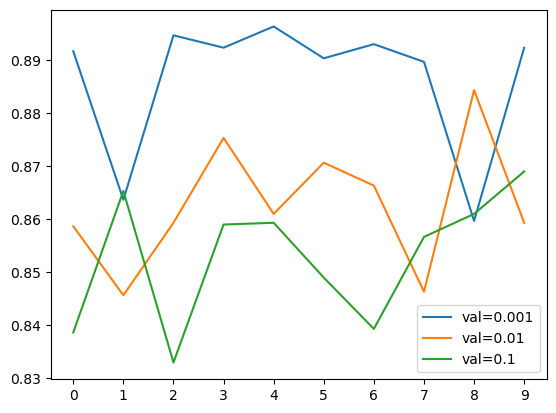

In [40]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [46]:
learning_rate=0.001

In [47]:
model.save_weights('model_inception_v3.h5', save_format='h5')

In [48]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'inception_v3_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [49]:
learning_rate = 0.001

model = make_model_inc(learning_rate=learning_rate)

history = model.fit(
    train_ds_inc,
    epochs=10,
    validation_data=val_ds_inc,
    callbacks=[chechpoint]
)

Epoch 1/10
439/439 [==============================] - 28s 55ms/step - loss: 0.4375 - accuracy: 0.8487 - val_loss: 0.3505 - val_accuracy: 0.8850
Epoch 2/10
439/439 [==============================] - 22s 51ms/step - loss: 0.3024 - accuracy: 0.8963 - val_loss: 0.3320 - val_accuracy: 0.8813
Epoch 3/10
439/439 [==============================] - 22s 51ms/step - loss: 0.2660 - accuracy: 0.9052 - val_loss: 0.3213 - val_accuracy: 0.8850
Epoch 4/10
439/439 [==============================] - 22s 51ms/step - loss: 0.2307 - accuracy: 0.9179 - val_loss: 0.2988 - val_accuracy: 0.9013
Epoch 5/10
439/439 [==============================] - 23s 51ms/step - loss: 0.2263 - accuracy: 0.9166 - val_loss: 0.3774 - val_accuracy: 0.8787
Epoch 6/10
439/439 [==============================] - 22s 49ms/step - loss: 0.2195 - accuracy: 0.9203 - val_loss: 0.3213 - val_accuracy: 0.8953
Epoch 7/10
439/439 [==============================] - 23s 51ms/step - loss: 0.1959 - accuracy: 0.9277 - val_loss: 0.3616 - val_accuracy:

In [16]:
def make_model_inc(learning_rate=0.01, size_inner=100):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [17]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model_inc(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds_inc, epochs=10, validation_data=val_ds_inc)
    scores[size] = history.history

    print()
    print()

10


2022-12-20 03:21:37.447136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 03:21:37.453253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 03:21:37.453867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 03:21:37.454785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10


2022-12-20 03:21:45.247195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-20 03:21:45.900156: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 03:21:45.901027: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 03:21:45.901075: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-20 03:21:45.902098: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 03:21:45.902197: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


439/439 [==============================] - 37s 70ms/step - loss: 0.4664 - accuracy: 0.8366 - val_loss: 0.3373 - val_accuracy: 0.8833
Epoch 2/10
439/439 [==============================] - 22s 49ms/step - loss: 0.3050 - accuracy: 0.8938 - val_loss: 0.3254 - val_accuracy: 0.8930
Epoch 3/10
439/439 [==============================] - 22s 50ms/step - loss: 0.2603 - accuracy: 0.9082 - val_loss: 0.3350 - val_accuracy: 0.8863
Epoch 4/10
439/439 [==============================] - 22s 50ms/step - loss: 0.2381 - accuracy: 0.9151 - val_loss: 0.3333 - val_accuracy: 0.8870
Epoch 5/10
439/439 [==============================] - 22s 49ms/step - loss: 0.2201 - accuracy: 0.9213 - val_loss: 0.2871 - val_accuracy: 0.9047
Epoch 6/10
439/439 [==============================] - 22s 49ms/step - loss: 0.2070 - accuracy: 0.9233 - val_loss: 0.3205 - val_accuracy: 0.8927
Epoch 7/10
439/439 [==============================] - 22s 49ms/step - loss: 0.1899 - accuracy: 0.9315 - val_loss: 0.3202 - val_accuracy: 0.8947
Epo

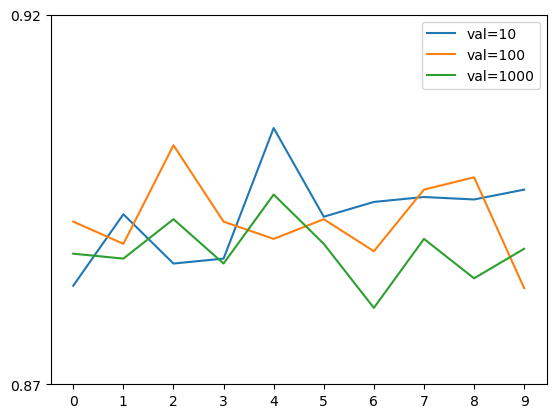

In [18]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.87, 0.92])
plt.legend()

In [21]:
def make_model_inc(learning_rate=0.01, size_inner=10, droprate=0.5):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [23]:
learning_rate = 0.001
size = 10

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model_inc(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds_inc, epochs=30, validation_data=val_ds_inc)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
439/439 [==============================] - 27s 52ms/step - loss: 0.6975 - accuracy: 0.8074 - val_loss: 0.4093 - val_accuracy: 0.8863
Epoch 2/30
439/439 [==============================] - 22s 50ms/step - loss: 0.3527 - accuracy: 0.8875 - val_loss: 0.3432 - val_accuracy: 0.8833
Epoch 3/30
439/439 [==============================] - 22s 50ms/step - loss: 0.2866 - accuracy: 0.9022 - val_loss: 0.3329 - val_accuracy: 0.8850
Epoch 4/30
439/439 [==============================] - 22s 50ms/step - loss: 0.2579 - accuracy: 0.9096 - val_loss: 0.3153 - val_accuracy: 0.8883
Epoch 5/30
439/439 [==============================] - 22s 50ms/step - loss: 0.2343 - accuracy: 0.9174 - val_loss: 0.3095 - val_accuracy: 0.8950
Epoch 6/30
439/439 [==============================] - 22s 49ms/step - loss: 0.2262 - accuracy: 0.9198 - val_loss: 0.3075 - val_accuracy: 0.8973
Epoch 7/30
439/439 [==============================] - 22s 50ms/step - loss: 0.2141 - accuracy: 0.9243 - val_loss: 0.3295 - val_accur

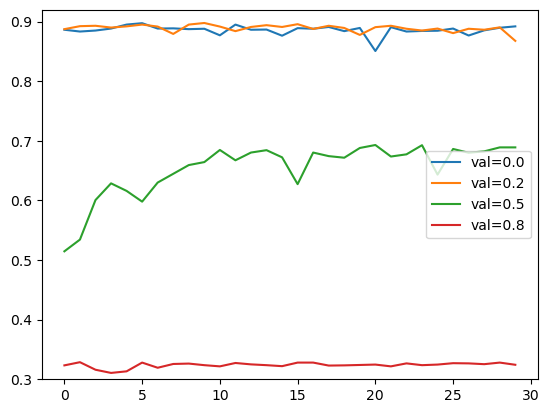

In [27]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.3, 0.92)
plt.legend()

In [29]:
def make_model_inc(learning_rate=0.01, size_inner=10):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [30]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds_inc = train_gen.flow_from_directory(
    'intel_image_classification/train',
    target_size=(150, 150),
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [31]:
learning_rate = 0.001
size = 10

model = make_model_inc(
    learning_rate=learning_rate,
    size_inner=size
)

history = model.fit(train_ds_inc, epochs=10, validation_data=val_ds_inc)

Epoch 1/10
439/439 [==============================] - 85s 186ms/step - loss: 0.7802 - accuracy: 0.7131 - val_loss: 0.4217 - val_accuracy: 0.8580
Epoch 2/10
439/439 [==============================] - 80s 183ms/step - loss: 0.4901 - accuracy: 0.8226 - val_loss: 0.3704 - val_accuracy: 0.8727
Epoch 3/10
439/439 [==============================] - 80s 183ms/step - loss: 0.4683 - accuracy: 0.8365 - val_loss: 0.3577 - val_accuracy: 0.8793
Epoch 4/10
439/439 [==============================] - 80s 182ms/step - loss: 0.4573 - accuracy: 0.8360 - val_loss: 0.3616 - val_accuracy: 0.8683
Epoch 5/10
439/439 [==============================] - 80s 182ms/step - loss: 0.4428 - accuracy: 0.8428 - val_loss: 0.3752 - val_accuracy: 0.8590
Epoch 6/10
439/439 [==============================] - 80s 183ms/step - loss: 0.4228 - accuracy: 0.8506 - val_loss: 0.4066 - val_accuracy: 0.8553
Epoch 7/10
439/439 [==============================] - 80s 183ms/step - loss: 0.4229 - accuracy: 0.8490 - val_loss: 0.3556 - val_ac

In [36]:
def make_model_inc(input_size=150,learning_rate=0.01, size_inner=10):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [28]:
input_size = 299

In [29]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
)

train_ds_inc = train_gen.flow_from_directory(
    'intel_image_classification/train',
    target_size=(input_size, input_size),
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [30]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds_inc = val_gen.flow_from_directory(
    'intel_image_classification/val',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3000 images belonging to 6 classes.


In [41]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'inception_v3_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [42]:
learning_rate = 0.0005
size = 10

model = make_model_inc(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size
)

history = model.fit(train_ds_inc, epochs=50, validation_data=val_ds_inc,
                   callbacks=[checkpoint])

Epoch 1/50
439/439 [==============================] - 69s 144ms/step - loss: 0.4248 - accuracy: 0.8575 - val_loss: 0.2563 - val_accuracy: 0.9090
Epoch 2/50
439/439 [==============================] - 60s 136ms/step - loss: 0.2381 - accuracy: 0.9152 - val_loss: 0.2501 - val_accuracy: 0.9050
Epoch 3/50
439/439 [==============================] - 60s 137ms/step - loss: 0.2160 - accuracy: 0.9214 - val_loss: 0.2267 - val_accuracy: 0.9180
Epoch 4/50
439/439 [==============================] - 61s 139ms/step - loss: 0.1978 - accuracy: 0.9287 - val_loss: 0.2180 - val_accuracy: 0.9193
Epoch 5/50
439/439 [==============================] - 61s 140ms/step - loss: 0.1884 - accuracy: 0.9298 - val_loss: 0.2177 - val_accuracy: 0.9207
Epoch 6/50
439/439 [==============================] - 61s 138ms/step - loss: 0.1792 - accuracy: 0.9331 - val_loss: 0.2142 - val_accuracy: 0.9197
Epoch 7/50
439/439 [==============================] - 61s 139ms/step - loss: 0.1711 - accuracy: 0.9374 - val_loss: 0.2175 - val_ac

In [20]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    'intel_image_classification/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 64 images belonging to 6 classes.


# Final model selection for deployment. 
### Both the model `Xception` and `inception` performance equally good. Model accuracy for test data images is exactly same.

In [21]:
X_model = keras.models.load_model('xception_v_1_11_0.930.h5')

2022-12-20 23:53:00.145773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:53:00.152408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:53:00.153023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:53:00.154025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [22]:
X_model.evaluate(test_ds)

2022-12-20 23:53:06.829040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-20 23:53:07.487262: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 23:53:07.488160: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 23:53:07.488204: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-20 23:53:07.489338: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 23:53:07.489437: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


2/2 [==============================] - 4s 207ms/step - loss: 0.1651 - accuracy: 0.9531


[0.1650601029396057, 0.953125]

In [23]:
inc_model = keras.models.load_model('inception_v3_1_10_0.927.h5')

In [24]:
inc_model.evaluate(test_ds)

2/2 [==============================] - 3s 106ms/step - loss: 0.1849 - accuracy: 0.9531


[0.18488270044326782, 0.953125]

### Accuracy of the both models are same. But loss is compartevely less for Xception model.

In [25]:
path1 = 'intel_image_classification/pred/building.jpg'
path2 = 'intel_image_classification/pred/Forest.jpg'
path3 = 'intel_image_classification/pred/Glacier.jpg'
path4 = 'intel_image_classification/pred/Mountain.jpg'
path5 = 'intel_image_classification/pred/sea.jpg'
path6 = 'intel_image_classification/pred/street.jpg'
img1 = load_img(path1, target_size=(299, 299))
img2 = load_img(path2, target_size=(299, 299))
img3 = load_img(path3, target_size=(299, 299))
img4 = load_img(path4, target_size=(299, 299))
img5 = load_img(path5, target_size=(299, 299))
img6 = load_img(path6, target_size=(299, 299))
x1 = np.array(img1)
x2 = np.array(img2)
x3 = np.array(img3)
x4 = np.array(img4)
x5 = np.array(img5)
x6 = np.array(img6)
X = np.array([x1, x2, x3, x4, x5, x6])
X = xc.preprocess_input(X)
pred = X_model.predict(X)
labels = train_ds.class_indices.keys()
res = []
for i in range(len(pred)):
    pred_dict = dict(zip(labels, pred[i]))
    res.append(max(pred_dict, key=pred_dict.get))
res

1/1 [==============================] - 1s 1s/step


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [31]:
path1 = 'intel_image_classification/pred/building.jpg'
path2 = 'intel_image_classification/pred/Forest.jpg'
path3 = 'intel_image_classification/pred/Glacier.jpg'
path4 = 'intel_image_classification/pred/Mountain.jpg'
path5 = 'intel_image_classification/pred/sea.jpg'
path6 = 'intel_image_classification/pred/street.jpg'
img1 = load_img(path1, target_size=(299, 299))
img2 = load_img(path2, target_size=(299, 299))
img3 = load_img(path3, target_size=(299, 299))
img4 = load_img(path4, target_size=(299, 299))
img5 = load_img(path5, target_size=(299, 299))
img6 = load_img(path6, target_size=(299, 299))
x1 = np.array(img1)
x2 = np.array(img2)
x3 = np.array(img3)
x4 = np.array(img4)
x5 = np.array(img5)
x6 = np.array(img6)
X = np.array([x1, x2, x3, x4, x5, x6])
X = preprocess_input(X)
pred = inc_model.predict(X)
labels = train_ds_inc.class_indices.keys()
res = []
for i in range(len(pred)):
    pred_dict = dict(zip(labels, pred[i]))
    res.append(max(pred_dict, key=pred_dict.get))
res

1/1 [==============================] - 0s 29ms/step


['buildings', 'forest', 'glacier', 'glacier', 'sea', 'street']

## Inception model fails to classify the mountain image and predicts as glacier

## We will consider Xception application for our final model deployment

## Converting tensorflow model into tensorflow lite.

In [32]:
model = keras.models.load_model('xception_v_1_11_0.930.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

model_lite = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpoqx008cz/assets


INFO:tensorflow:Assets written to: /tmp/tmpoqx008cz/assets
2022-12-20 23:59:44.623485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-20 23:59:44.623532: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-20 23:59:44.624303: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpoqx008cz
2022-12-20 23:59:44.651689: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-12-20 23:59:44.651719: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpoqx008cz
2022-12-20 23:59:44.751586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-20 23:59:44.777465: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-12-20 23:59:45.277526: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

In [33]:
with open('xception_model.tflite', 'wb') as f_out:
    f_out.write(model_lite)